## NHL Game Prediction Model

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from datetime import datetime
from collections import defaultdict
from sklearn import linear_model, svm, ensemble
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scrapenhl2.scrape import autoupdate, schedules, team_info, players, teams, games, parse_pbp, team_info
from scrapenhl2.manipulate import manipulate as manip
from scrapenhl2.plot import game_h2h, game_timeline, team_score_shot_rate
import scrapenhl2.manipulate.add_onice_players as onice

# Update with stats
autoupdate.autoupdate()
print("Pandas Version ",pd.__version__)

/Users/robbowen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robbowen/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Parsing Games: 0it [00:00, ?it/s]

Updating in-progress games
Updating final games
Updating team log for 2017 NJD


Done with team logs for 2017 NJD (1/31)
Updating team log for 2017 NYI
Done with team logs for 2017 NYI (2/31)
Updating team log for 2017 NYR
Done with team logs for 2017 NYR (3/31)
Updating team log for 2017 PHI
Done with team logs for 2017 PHI (4/31)
Updating team log for 2017 PIT
Done with team logs for 2017 PIT (5/31)
Updating team log for 2017 BOS
Pandas Version  0.20.3


In [2]:
# Read data 
NHLTeams = pd.read_csv('NHLTeams.csv')

# Preview data.
#display(NHLTeams)

In [3]:
# Function to replace team id with name, pass in df and column, return changed df
def team_replace_home_column(df, home_col):
    df[home_col].replace([24],['Anaheim Ducks'],inplace=True)
    df[home_col].replace([53],['Arizona Coyotes'],inplace=True)
    #df[home_col].replace([11],['Atlanta Thrashers'],inplace=True)
    df[home_col].replace([6],['Boston Bruins'],inplace=True)
    df[home_col].replace([7],['Buffalo Sabres'],inplace=True)
    df[home_col].replace([20],['Calgary Flames'],inplace=True)
    df[home_col].replace([12],['Carolina Hurricanes'],inplace=True)
    df[home_col].replace([16],['Chicago Blackhawks'],inplace=True)
    df[home_col].replace([21],['Colorado Avalanche'],inplace=True)
    df[home_col].replace([29],['Columbus Blue Jackets'],inplace=True)
    df[home_col].replace([25],['Dallas Stars'],inplace=True)
    df[home_col].replace([17],['Detroit Red Wings'],inplace=True)
    df[home_col].replace([22],['Edmonton Oilers'],inplace=True)
    df[home_col].replace([13],['Florida Panthers'],inplace=True)
    df[home_col].replace([26],['Los Angeles Kings'],inplace=True)
    df[home_col].replace([30],['Minnesota Wild'],inplace=True)
    #df[home_col].replace([31],['Minnesota North Stars'],inplace=True)
    df[home_col].replace([8],['Montreal Canadiens'],inplace=True)
    df[home_col].replace([18],['Nashville Predators'],inplace=True)
    df[home_col].replace([1],['New Jersey Devils'],inplace=True)
    df[home_col].replace([2],['New York Islanders'],inplace=True)
    df[home_col].replace([3],['New York Rangers'],inplace=True)
    df[home_col].replace([9],['Ottawa Senators'],inplace=True)
    #df[home_col].replace([27],['Pheonix Coyotes'],inplace=True)
    df[home_col].replace([4],['Philadelphia Flyers'],inplace=True)
    df[home_col].replace([5],['Pittsburgh Penguins'],inplace=True)
    #df[home_col].replace([32],['Quebec Nordiques'],inplace=True)
    df[home_col].replace([28],['San Jose Sharks'],inplace=True)
    df[home_col].replace([19],['St. Louis Blues'],inplace=True)
    df[home_col].replace([14],['Tampa Bay Lightning'],inplace=True)
    df[home_col].replace([10],['Toronto Maple Leafs'],inplace=True)
    df[home_col].replace([23],['Vancouver Canucks'],inplace=True)
    df[home_col].replace([54],['Vegas Golden Knights'],inplace=True)
    df[home_col].replace([15],['Washingotn Capitals'],inplace=True)
    df[home_col].replace([52],['Winnipeg Jets'],inplace=True)
    df[home_col].replace([87],['Atlantic Division All Stars'],inplace=True)
    df[home_col].replace([88],['Metropolitan Division All Stars'],inplace=True)
    df[home_col].replace([89],['Central Division All Stars'],inplace=True)
    df[home_col].replace([90],['Pacific Division All Stars'],inplace=True)

    return df

def team_replace_road_column(df, road_col):
    df[road_col].replace([24],['Anaheim Ducks'],inplace=True)
    df[road_col].replace([53],['Arizona Coyotes'],inplace=True)
    #df[road_col].replace([11],['Atlanta Thrashers'],inplace=True)
    df[road_col].replace([6],['Boston Bruins'],inplace=True)
    df[road_col].replace([7],['Buffalo Sabres'],inplace=True)
    df[road_col].replace([20],['Calgary Flames'],inplace=True)
    df[road_col].replace([12],['Carolina Hurricanes'],inplace=True)
    df[road_col].replace([16],['Chicago Blackhawks'],inplace=True)
    df[road_col].replace([21],['Colorado Avalanche'],inplace=True)
    df[road_col].replace([29],['Columbus Blue Jackets'],inplace=True)
    df[road_col].replace([25],['Dallas Stars'],inplace=True)
    df[road_col].replace([17],['Detroit Red Wings'],inplace=True)
    df[road_col].replace([22],['Edmonton Oilers'],inplace=True)
    df[road_col].replace([13],['Florida Panthers'],inplace=True)
    df[road_col].replace([26],['Los Angeles Kings'],inplace=True)
    df[road_col].replace([30],['Minnesota Wild'],inplace=True)
    #df[road_col].replace([31],['Minnesota North Stars'],inplace=True)
    df[road_col].replace([8],['Montreal Canadiens'],inplace=True)
    df[road_col].replace([18],['Nashville Predators'],inplace=True)
    df[road_col].replace([1],['New Jersey Devils'],inplace=True)
    df[road_col].replace([2],['New York Islanders'],inplace=True)
    df[road_col].replace([3],['New York Rangers'],inplace=True)
    df[road_col].replace([9],['Ottawa Senators'],inplace=True)
    #df[road_col].replace([27],['Pheonix Coyotes'],inplace=True)
    df[road_col].replace([4],['Philadelphia Flyers'],inplace=True)
    df[road_col].replace([5],['Pittsburgh Penguins'],inplace=True)
    #df[road_col].replace([32],['Quebec Nordiques'],inplace=True)
    df[road_col].replace([28],['San Jose Sharks'],inplace=True)
    df[road_col].replace([19],['St. Louis Blues'],inplace=True)
    df[road_col].replace([14],['Tampa Bay Lightning'],inplace=True)
    df[road_col].replace([10],['Toronto Maple Leafs'],inplace=True)
    df[road_col].replace([23],['Vancouver Canucks'],inplace=True)
    df[road_col].replace([54],['Vegas Golden Knights'],inplace=True)
    df[road_col].replace([15],['Washingotn Capitals'],inplace=True)
    df[road_col].replace([52],['Winnipeg Jets'],inplace=True)
    df[road_col].replace([87],['Atlantic Division All Stars'],inplace=True)
    df[road_col].replace([88],['Metropolitan Division All Stars'],inplace=True)
    df[road_col].replace([89],['Central Division All Stars'],inplace=True)
    df[road_col].replace([90],['Pacific Division All Stars'],inplace=True)
   
    return df


In [4]:
# Get training schedules and concat together
sched_2015 = schedules.get_season_schedule(2015)
sched_2016 = schedules.get_season_schedule(2016)
frames = [sched_2015, sched_2016]
sched_train = pd.concat(frames)

# Organize training data/Reset Index [Remove AllStar, Preseason, and Playoff games]
sched_train = sched_train[sched_train.Type != 'A']

# Replace Team IDs with team names
sched_train = team_replace_home_column(sched_train, 'Home')
sched_train = team_replace_road_column(sched_train, 'Road')

# Add Feature Columns
sched_train['HomeWin'] = sched_train['RoadScore'] < sched_train['HomeScore']
sched_train['HomeLastWin'] = False
sched_train['RoadLastWin'] = False
sched_train['HomeWinStreak'] = 0
sched_train['RoadWinStreak'] = 0
sched_train['HomeGoalsPerGame'] = 0
sched_train['RoadGoalsPerGame'] = 0
sched_train['HomeGoalsAgainstPerGame'] = 0
sched_train['RoadGoalsAgainstPerGame'] = 0
sched_train['HomeWonLastMeeting'] = False
sched_train['HomeBackToBack'] = False
sched_train['RoadBackToBack'] = False

# Remove unnecessary columns
del sched_train['Game']
del sched_train['HomeCoach']
del sched_train['RoadCoach']
del sched_train['PBPStatus']
del sched_train['TOIStatus']
del sched_train['Venue']
del sched_train['Season'] 

# Vegas row to allow team feature to carry over from train to test data properly
df1 = pd.DataFrame({'Date': ['2017-05-10'],
                    'Home': ['Vegas Golden Knights'],
                    'HomeBackToBack': [False],
                    'HomeGoalsPerGame': [0],
                    'HomeGoalsAgainstPerGame': [0],
                    'HomeLastWin': [False],
                    'HomeScore': [1],
                    'HomeWinStreak': [0],
                    'HomeWonLastMeeting': [False],
                    'Road': ['Vegas Golden Knights'],
                    'RoadBackToBack': [False],
                    'RoadGoalsPerGame': [0],
                    'RoadGoalsAgainstPerGame': [0], 
                    'RoadLastWin': [False],
                    'RoadScore': [0],
                    'RoadWinStreak': [0],
                    'Status': ['Final'],
                    'Type': ['R'],
                    'Result': ['W'],
                    'HomeWin': [True],
                   })


sched_train = pd.concat([sched_train, df1])
sched_train.index = pd.RangeIndex(len(sched_train.index))
display(sched_train)

,Date,Home,HomeBackToBack,HomeGoalsAgainstPerGame,HomeGoalsPerGame,HomeLastWin,HomeScore,HomeWin,HomeWinStreak,HomeWonLastMeeting,Result,Road,RoadBackToBack,RoadGoalsAgainstPerGame,RoadGoalsPerGame,RoadLastWin,RoadScore,RoadWinStreak,Status,Type
0,2015-09-20,Boston Bruins,False,0,0,False,2,True,0,False,W,New Jersey Devils,False,0,0,False,0,0,Final,PR
1,2015-09-20,Nashville Predators,False,0,0,False,5,True,0,False,W,Florida Panthers,False,0,0,False,2,0,Final,PR
2,2015-09-20,Nashville Predators,False,0,0,False,2,False,0,False,OTL,Florida Panthers,False,0,0,False,3,0,Final,PR
3,2015-09-21,Arizona Coyotes,False,0,0,False,1,False,0,False,L,Los Angeles Kings,False,0,0,False,5,0,Final,PR
4,2015-09-21,Calgary Flames,False,0,0,False,1,False,0,False,L,Edmonton Oilers,False,0,0,False,3,0,Final,PR
5,2015-09-21,Columbus Blue Jackets,False,0,0,False,0,False,0,False,SOL,Pittsburgh Penguins,False,0,0,False,1,0,Final,PR
6,2015-09-21,Edmonton Oilers,False,0,0,False,4,True,0,False,W,Calgary Flames,False,0,0,False,2,0,Final,PR
7,2015-09-21,Minnesota Wild,False,0,0,False,2,False,0,False,L,Buffalo Sabres,False,0,0,False,3,0,Final,PR
8,2015-09-21,New York Islanders,False,0,0,False,3,True,0,False,W,Philadelphia Flyers,False,0,0,False,2,0,Final,PR
9,2015-09-21,New York Rangers,False,0,0,False,6,True,0,False,W,New Jersey Devils,False,0,0,False,3,0,Final,PR


In [5]:
# Get test schedule for 2017
sched = schedules.get_season_schedule(2017)

# Organize training data/Reset Index [Remove AllStar, Preseason, and Playoff games]
sched = sched[sched.Type != 'A']
emptydf = pd.DataFrame()
temp = [emptydf, sched]
sched_test = pd.concat(temp)

# Replace Team IDs with team names
sched_test = team_replace_home_column(sched_test, 'Home')
sched_test = team_replace_road_column(sched_test, 'Road')


# Add Feature Columns
sched_test['HomeWin'] = sched_test['RoadScore'] < sched_test['HomeScore']
sched_test['HomeLastWin'] = False
sched_test['RoadLastWin'] = False
sched_test['HomeWinStreak'] = 0
sched_test['RoadWinStreak'] = 0
sched_test['HomeGoalsPerGame'] = 0
sched_test['RoadGoalsPerGame'] = 0
sched_test['HomeGoalsAgainstPerGame'] = 0
sched_test['RoadGoalsAgainstPerGame'] = 0
sched_test['HomeWonLastMeeting'] = False
sched_test['HomeBackToBack'] = False
sched_test['RoadBackToBack'] = False

# Remove unnecessary columns
del sched_test['Game']
del sched_test['HomeCoach']
del sched_test['RoadCoach']
del sched_test['PBPStatus']
del sched_test['TOIStatus']
del sched_test['Venue']
del sched_test['Season'] 



sched_test.index = pd.RangeIndex(len(sched_test.index))
display(sched_test)



,Date,Home,HomeScore,Road,RoadScore,Status,Type,Result,HomeWin,HomeLastWin,RoadLastWin,HomeWinStreak,RoadWinStreak,HomeGoalsPerGame,RoadGoalsPerGame,HomeGoalsAgainstPerGame,RoadGoalsAgainstPerGame,HomeWonLastMeeting,HomeBackToBack,RoadBackToBack
0,2017-09-16,Los Angeles Kings,3,Vancouver Canucks,4,Final,PR,OTL,False,False,False,0,0,0,0,0,0,False,False,False
1,2017-09-17,Vancouver Canucks,4,Vegas Golden Knights,9,Final,PR,L,False,False,False,0,0,0,0,0,0,False,False,False
2,2017-09-17,New York Islanders,3,Philadelphia Flyers,2,Final,PR,OTW,True,False,False,0,0,0,0,0,0,False,False,False
3,2017-09-18,Edmonton Oilers,5,Calgary Flames,2,Final,PR,W,True,False,False,0,0,0,0,0,0,False,False,False
4,2017-09-18,Buffalo Sabres,2,Carolina Hurricanes,3,Final,PR,OTL,False,False,False,0,0,0,0,0,0,False,False,False
5,2017-09-18,Calgary Flames,4,Edmonton Oilers,5,Final,PR,L,False,False,False,0,0,0,0,0,0,False,False,False
6,2017-09-18,Winnipeg Jets,2,Minnesota Wild,3,Final,PR,SOL,False,False,False,0,0,0,0,0,0,False,False,False
7,2017-09-18,Boston Bruins,3,Montreal Canadiens,2,Final,PR,W,True,False,False,0,0,0,0,0,0,False,False,False
8,2017-09-18,New York Rangers,1,New York Islanders,0,Final,PR,OTW,True,False,False,0,0,0,0,0,0,False,False,False
9,2017-09-18,Ottawa Senators,6,Toronto Maple Leafs,2,Final,PR,W,True,False,False,0,0,0,0,0,0,False,False,False


In [6]:
# Calc actual home winning percentage and f1_score
scorer = make_scorer(f1_score, pos_label=None, average = 'weighted')
y_training = sched_train['HomeWin'].values

# Get Test y values [Actual result for home team]
y_test = sched_test['HomeWin']

n_games = sched_train['HomeWin'].count()
n_homewins = sched_train['HomeWin'].sum()
homewin_pct = n_homewins / n_games
print("Train Home Win Percentage: {0: .2f}%".format(100*homewin_pct))

n_games = sched_test['HomeWin'].count()
n_homewins = sched_test['HomeWin'].sum()
homewin_pct = n_homewins / n_games
print("Test Home Win Percentage: {0: .2f}%".format(100*homewin_pct))

y_pred = [1] * len(y_training)
print("F1: {0: .2f}%".format(100*f1_score(y_training, y_pred, pos_label=None, average='weighted')))


Train Home Win Percentage:  54.74%
Test Home Win Percentage:  55.79%
F1:  38.73%


/Users/robbowen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
# Last Game Result Features
won_last = defaultdict(int)

for index, row in sched_train.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    row['HomeLastWin'] = won_last[home_team]
    row['RoadLastWin'] = won_last[road_team]
    sched_train.iloc[index] = row
    won_last[home_team] = row['HomeWin']
    won_last[road_team] = not row['HomeWin']
    
# Testing df features  
for index, row in sched_test.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    row['HomeLastWin'] = won_last[home_team]
    row['RoadLastWin'] = won_last[road_team]
    sched_test.iloc[index] = row
    won_last[home_team] = row['HomeWin']
    won_last[road_team] = not row['HomeWin']
    
X_TEST = sched_test[['HomeLastWin', 'RoadLastWin']].values
display(sched_train)

,Date,Home,HomeBackToBack,HomeGoalsAgainstPerGame,HomeGoalsPerGame,HomeLastWin,HomeScore,HomeWin,HomeWinStreak,HomeWonLastMeeting,Result,Road,RoadBackToBack,RoadGoalsAgainstPerGame,RoadGoalsPerGame,RoadLastWin,RoadScore,RoadWinStreak,Status,Type
0,2015-09-20,Boston Bruins,False,0,0,False,2,True,0,False,W,New Jersey Devils,False,0,0,False,0,0,Final,PR
1,2015-09-20,Nashville Predators,False,0,0,False,5,True,0,False,W,Florida Panthers,False,0,0,False,2,0,Final,PR
2,2015-09-20,Nashville Predators,False,0,0,True,2,False,0,False,OTL,Florida Panthers,False,0,0,False,3,0,Final,PR
3,2015-09-21,Arizona Coyotes,False,0,0,False,1,False,0,False,L,Los Angeles Kings,False,0,0,False,5,0,Final,PR
4,2015-09-21,Calgary Flames,False,0,0,False,1,False,0,False,L,Edmonton Oilers,False,0,0,False,3,0,Final,PR
5,2015-09-21,Columbus Blue Jackets,False,0,0,False,0,False,0,False,SOL,Pittsburgh Penguins,False,0,0,False,1,0,Final,PR
6,2015-09-21,Edmonton Oilers,False,0,0,True,4,True,0,False,W,Calgary Flames,False,0,0,False,2,0,Final,PR
7,2015-09-21,Minnesota Wild,False,0,0,False,2,False,0,False,L,Buffalo Sabres,False,0,0,False,3,0,Final,PR
8,2015-09-21,New York Islanders,False,0,0,False,3,True,0,False,W,Philadelphia Flyers,False,0,0,False,2,0,Final,PR
9,2015-09-21,New York Rangers,False,0,0,False,6,True,0,False,W,New Jersey Devils,False,0,0,False,3,0,Final,PR


In [8]:
# Test model with Last Win features
X_features = sched_train[['HomeLastWin', 'RoadLastWin']].values
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_features, y_training, scoring = scorer)
print("Using the last result from the home and road teams:")
print("F1: {0: .2f}%".format(100*np.mean(scores)))

Using the last result from the home and road teams:
F1:  38.73%


/Users/robbowen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/robbowen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/robbowen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
# Add feature for win streaks

win_streak = defaultdict(int)
for index, row in sched_train.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    row['HomeWinStreak'] = win_streak[home_team]
    row['RoadWinStreak'] = win_streak[road_team]
    sched_train.iloc[index] = row
    #Update streaks
    if row['HomeWin']:
        win_streak[home_team] += 1
        win_streak[road_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[road_team] += 1

# Test df features
win_streak_test = defaultdict(int)
for index, row in sched_test.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    row['HomeWinStreak'] = win_streak_test[home_team]
    row['RoadWinStreak'] = win_streak_test[road_team]
    sched_test.iloc[index] = row
    #Update streaks
    if row['HomeWin']:
        win_streak_test[home_team] += 1
        win_streak_test[road_team] = 0
    else:
        win_streak_test[home_team] = 0
        win_streak_test[road_team] += 1
        
display(sched_test)

,Date,Home,HomeScore,Road,RoadScore,Status,Type,Result,HomeWin,HomeLastWin,RoadLastWin,HomeWinStreak,RoadWinStreak,HomeGoalsPerGame,RoadGoalsPerGame,HomeGoalsAgainstPerGame,RoadGoalsAgainstPerGame,HomeWonLastMeeting,HomeBackToBack,RoadBackToBack
0,2017-09-16,Los Angeles Kings,3,Vancouver Canucks,4,Final,PR,OTL,False,False,False,0,0,0,0,0,0,False,False,False
1,2017-09-17,Vancouver Canucks,4,Vegas Golden Knights,9,Final,PR,L,False,True,False,1,0,0,0,0,0,False,False,False
2,2017-09-17,New York Islanders,3,Philadelphia Flyers,2,Final,PR,OTW,True,True,False,0,0,0,0,0,0,False,False,False
3,2017-09-18,Edmonton Oilers,5,Calgary Flames,2,Final,PR,W,True,False,False,0,0,0,0,0,0,False,False,False
4,2017-09-18,Buffalo Sabres,2,Carolina Hurricanes,3,Final,PR,OTL,False,False,True,0,0,0,0,0,0,False,False,False
5,2017-09-18,Calgary Flames,4,Edmonton Oilers,5,Final,PR,L,False,False,True,0,1,0,0,0,0,False,False,False
6,2017-09-18,Winnipeg Jets,2,Minnesota Wild,3,Final,PR,SOL,False,True,False,0,0,0,0,0,0,False,False,False
7,2017-09-18,Boston Bruins,3,Montreal Canadiens,2,Final,PR,W,True,False,False,0,0,0,0,0,0,False,False,False
8,2017-09-18,New York Rangers,1,New York Islanders,0,Final,PR,OTW,True,False,True,0,1,0,0,0,0,False,False,False
9,2017-09-18,Ottawa Senators,6,Toronto Maple Leafs,2,Final,PR,W,True,False,False,0,0,0,0,0,0,False,False,False


In [10]:
# Test model with Last Win AND Win Streak features
X_TEST = sched_test[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak']].values
X_features = sched_train[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak']].values
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_features, y_training, scoring = scorer)
print("Using the last result from the home and road teams and there win streak:")
print("F1: {0: .2f}%".format(100*np.mean(scores)))

Using the last result from the home and road teams and there win streak:
F1:  46.47%


In [11]:
# Feature for standings of previous year
# standings_2017 = get_standings(2017)
# NEED TO SET INDEX TO TEAM NAME
# AT 18:17 at https://www.youtube.com/watch?v=k7hSD_-gWMw


In [12]:

# EXAMPLE of tuning parameters for last win and win streak features
parameter_space = {"max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
clf = DecisionTreeClassifier(random_state = 14)
grid = GridSearchCV(clf, parameter_space, scoring=scorer)
grid.fit(X_features, y_training)
print("Tuning Parameters:")
print("F1: {0: .2f}%".format(100*grid.best_score_))

/Users/robbowen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/robbowen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Tuning Parameters:
F1:  46.80%


In [13]:
# Feature to determine who won the last meeting between these two teams
last_meeting_winner = defaultdict(int)

def prev_meeting_winner(row):
    home_team = row['Home']
    road_team = row['Road']
    
    # Sort for consistent ordering
    teams = tuple(sorted([home_team, road_team]))
    result = 1 if last_meeting_winner[teams] == row['Home'] else 0
    # Update dict for next encounter
    winner = row['Home'] if row['HomeWin'] else ['Road']
    last_meeting_winner[teams] = winner
    
    return result

sched_train['HomeWonLastMeeting'] = sched_train.apply(prev_meeting_winner, axis=1)

# Test df Feature
sched_test['HomeWonLastMeeting'] = sched_test.apply(prev_meeting_winner, axis=1)
X_TEST = sched_test[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak', 'HomeWonLastMeeting']].values
sched_test

,Date,Home,HomeScore,Road,RoadScore,Status,Type,Result,HomeWin,HomeLastWin,RoadLastWin,HomeWinStreak,RoadWinStreak,HomeGoalsPerGame,RoadGoalsPerGame,HomeGoalsAgainstPerGame,RoadGoalsAgainstPerGame,HomeWonLastMeeting,HomeBackToBack,RoadBackToBack
0,2017-09-16,Los Angeles Kings,3,Vancouver Canucks,4,Final,PR,OTL,False,False,False,0,0,0,0,0,0,0,False,False
1,2017-09-17,Vancouver Canucks,4,Vegas Golden Knights,9,Final,PR,L,False,True,False,1,0,0,0,0,0,0,False,False
2,2017-09-17,New York Islanders,3,Philadelphia Flyers,2,Final,PR,OTW,True,True,False,0,0,0,0,0,0,0,False,False
3,2017-09-18,Edmonton Oilers,5,Calgary Flames,2,Final,PR,W,True,False,False,0,0,0,0,0,0,0,False,False
4,2017-09-18,Buffalo Sabres,2,Carolina Hurricanes,3,Final,PR,OTL,False,False,True,0,0,0,0,0,0,0,False,False
5,2017-09-18,Calgary Flames,4,Edmonton Oilers,5,Final,PR,L,False,False,True,0,1,0,0,0,0,0,False,False
6,2017-09-18,Winnipeg Jets,2,Minnesota Wild,3,Final,PR,SOL,False,True,False,0,0,0,0,0,0,1,False,False
7,2017-09-18,Boston Bruins,3,Montreal Canadiens,2,Final,PR,W,True,False,False,0,0,0,0,0,0,1,False,False
8,2017-09-18,New York Rangers,1,New York Islanders,0,Final,PR,OTW,True,False,True,0,1,0,0,0,0,0,False,False
9,2017-09-18,Ottawa Senators,6,Toronto Maple Leafs,2,Final,PR,W,True,False,False,0,0,0,0,0,0,0,False,False


In [14]:
# Test model with Last Win AND Win Streak AND Winner of Last Encounter features
X_features = sched_train[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak', 'HomeWonLastMeeting']].values
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_features, y_training, scoring = scorer)
print("Using the last result from the home and road teams and there win streak:")
print("F1: {0: .2f}%".format(100*np.mean(scores)))

Using the last result from the home and road teams and there win streak:
F1:  47.07%


In [15]:
# Add feature for goals for per game
# WHEN DOING GOALS FOR PER GAME MAYBE RESET WHEN SEASON TURNS OVER

goals_pergame_train = defaultdict(int)
games_played_train = defaultdict(int)
goals_for_train = defaultdict(int)

for index, row in sched_train.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    row['HomeGoalsPerGame'] = goals_pergame_train[home_team]
    row['RoadGoalsPerGame'] = goals_pergame_train[road_team]
    goals_for_train[home_team] += row['HomeScore']
    goals_for_train[road_team] += row['RoadScore']
    sched_train.iloc[index] = row
    
    #Update stats
    games_played_train[home_team] += 1
    games_played_train[road_team] += 1
    goals_pergame_train[home_team] = goals_for_train[home_team]/games_played_train[home_team]
    goals_pergame_train[road_team] = goals_for_train[road_team]/games_played_train[road_team]

# Test df features
goals_pergame_test = defaultdict(int)
games_played_test = defaultdict(int)
goals_for_test = defaultdict(int)

for index, row in sched_test.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    row['HomeGoalsPerGame'] = goals_pergame_test[home_team]
    row['RoadGoalsPerGame'] = goals_pergame_test[road_team]
    goals_for_test[home_team] += row['HomeScore']
    goals_for_test[road_team] += row['RoadScore']
    sched_test.iloc[index] = row
    
    #Update stats
    games_played_test[home_team] += 1
    games_played_test[road_team] += 1
    goals_pergame_test[home_team] = goals_for_test[home_team]/games_played_test[home_team]
    goals_pergame_test[road_team] = goals_for_test[road_team]/games_played_test[road_team]
        
X_TEST = sched_test[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak', 'HomeGoalsPerGame', 'RoadGoalsPerGame', 'HomeWonLastMeeting']].values

sched_train

,Date,Home,HomeBackToBack,HomeGoalsAgainstPerGame,HomeGoalsPerGame,HomeLastWin,HomeScore,HomeWin,HomeWinStreak,HomeWonLastMeeting,Result,Road,RoadBackToBack,RoadGoalsAgainstPerGame,RoadGoalsPerGame,RoadLastWin,RoadScore,RoadWinStreak,Status,Type
0,2015-09-20,Boston Bruins,False,0,0.000000,False,2,True,0,0,W,New Jersey Devils,False,0,0.000000,False,0,0,Final,PR
1,2015-09-20,Nashville Predators,False,0,0.000000,False,5,True,0,0,W,Florida Panthers,False,0,0.000000,False,2,0,Final,PR
2,2015-09-20,Nashville Predators,False,0,5.000000,True,2,False,1,1,OTL,Florida Panthers,False,0,2.000000,False,3,0,Final,PR
3,2015-09-21,Arizona Coyotes,False,0,0.000000,False,1,False,0,0,L,Los Angeles Kings,False,0,0.000000,False,5,0,Final,PR
4,2015-09-21,Calgary Flames,False,0,0.000000,False,1,False,0,0,L,Edmonton Oilers,False,0,0.000000,False,3,0,Final,PR
5,2015-09-21,Columbus Blue Jackets,False,0,0.000000,False,0,False,0,0,SOL,Pittsburgh Penguins,False,0,0.000000,False,1,0,Final,PR
6,2015-09-21,Edmonton Oilers,False,0,3.000000,True,4,True,1,0,W,Calgary Flames,False,0,1.000000,False,2,0,Final,PR
7,2015-09-21,Minnesota Wild,False,0,0.000000,False,2,False,0,0,L,Buffalo Sabres,False,0,0.000000,False,3,0,Final,PR
8,2015-09-21,New York Islanders,False,0,0.000000,False,3,True,0,0,W,Philadelphia Flyers,False,0,0.000000,False,2,0,Final,PR
9,2015-09-21,New York Rangers,False,0,0.000000,False,6,True,0,0,W,New Jersey Devils,False,0,0.000000,False,3,0,Final,PR


In [16]:
# Test model with Goals For
X_features = sched_train[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak', 'HomeGoalsPerGame', 'RoadGoalsPerGame', 'HomeWonLastMeeting']].values
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_features, y_training, scoring = scorer)
print("F1: {0: .2f}%".format(100*np.mean(scores)))

F1:  52.33%


In [17]:
# Add feature for goals against per game
# WHEN DOING GOALS AGAINST PER GAME MAYBE RESET WHEN SEASON TURNS OVER

goals_againstpergame_train = defaultdict(int)
games_played_train = defaultdict(int)
goals_against_train = defaultdict(int)

for index, row in sched_train.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    row['HomeGoalsAgainstPerGame'] = goals_againstpergame_train[home_team]
    row['RoadGoalsAgainstPerGame'] = goals_againstpergame_train[road_team]
    # SAME AS GOALS FOR HERE EXCEPT TAKING GOALS AGAINST THATS WHY ITS OPPOSITE FOR EACH TEAM
    goals_against_train[home_team] += row['RoadScore']
    goals_against_train[road_team] += row['HomeScore']
    sched_train.iloc[index] = row
    
    #Update stats
    games_played_train[home_team] += 1
    games_played_train[road_team] += 1
    goals_againstpergame_train[home_team] = goals_against_train[home_team]/games_played_train[home_team]
    goals_againstpergame_train[road_team] = goals_against_train[road_team]/games_played_train[road_team]

# Test df features
goals_againstpergame_test = defaultdict(int)
games_played_test = defaultdict(int)
goals_against_test = defaultdict(int)

for index, row in sched_test.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    row['HomeGoalsAgainstPerGame'] = goals_againstpergame_test[home_team]
    row['RoadGoalsAgainstPerGame'] = goals_againstpergame_test[road_team]
    goals_against_test[home_team] += row['RoadScore']
    goals_against_test[road_team] += row['HomeScore']
    sched_test.iloc[index] = row
    
    #Update stats
    games_played_test[home_team] += 1
    games_played_test[road_team] += 1
    goals_againstpergame_test[home_team] = goals_against_test[home_team]/games_played_test[home_team]
    goals_againstpergame_test[road_team] = goals_against_test[road_team]/games_played_test[road_team]
        
X_TEST = sched_test[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak', 'HomeGoalsPerGame', 'RoadGoalsPerGame', 'HomeGoalsAgainstPerGame', 'RoadGoalsAgainstPerGame', 'HomeWonLastMeeting']].values

sched_train

,Date,Home,HomeBackToBack,HomeGoalsAgainstPerGame,HomeGoalsPerGame,HomeLastWin,HomeScore,HomeWin,HomeWinStreak,HomeWonLastMeeting,Result,Road,RoadBackToBack,RoadGoalsAgainstPerGame,RoadGoalsPerGame,RoadLastWin,RoadScore,RoadWinStreak,Status,Type
0,2015-09-20,Boston Bruins,False,0.000000,0.000000,False,2,True,0,0,W,New Jersey Devils,False,0.000000,0.000000,False,0,0,Final,PR
1,2015-09-20,Nashville Predators,False,0.000000,0.000000,False,5,True,0,0,W,Florida Panthers,False,0.000000,0.000000,False,2,0,Final,PR
2,2015-09-20,Nashville Predators,False,2.000000,5.000000,True,2,False,1,1,OTL,Florida Panthers,False,5.000000,2.000000,False,3,0,Final,PR
3,2015-09-21,Arizona Coyotes,False,0.000000,0.000000,False,1,False,0,0,L,Los Angeles Kings,False,0.000000,0.000000,False,5,0,Final,PR
4,2015-09-21,Calgary Flames,False,0.000000,0.000000,False,1,False,0,0,L,Edmonton Oilers,False,0.000000,0.000000,False,3,0,Final,PR
5,2015-09-21,Columbus Blue Jackets,False,0.000000,0.000000,False,0,False,0,0,SOL,Pittsburgh Penguins,False,0.000000,0.000000,False,1,0,Final,PR
6,2015-09-21,Edmonton Oilers,False,1.000000,3.000000,True,4,True,1,0,W,Calgary Flames,False,3.000000,1.000000,False,2,0,Final,PR
7,2015-09-21,Minnesota Wild,False,0.000000,0.000000,False,2,False,0,0,L,Buffalo Sabres,False,0.000000,0.000000,False,3,0,Final,PR
8,2015-09-21,New York Islanders,False,0.000000,0.000000,False,3,True,0,0,W,Philadelphia Flyers,False,0.000000,0.000000,False,2,0,Final,PR
9,2015-09-21,New York Rangers,False,0.000000,0.000000,False,6,True,0,0,W,New Jersey Devils,False,2.000000,0.000000,False,3,0,Final,PR


In [18]:
# Test model with Goals Against
X_features = sched_train[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak', 'HomeGoalsAgainstPerGame', 'RoadGoalsAgainstPerGame', 'HomeGoalsPerGame', 'RoadGoalsPerGame', 'HomeWonLastMeeting']].values
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_features, y_training, scoring = scorer)
print("F1: {0: .2f}%".format(100*np.mean(scores)))

F1:  50.25%


In [19]:
# Feature if team is on the second game of a Back To Back
last_game = defaultdict(str)

for index, row in sched_train.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    # Get current date which is from row, and get last game date from dict
    current_gameday = row['Date']
    last_home_game = last_game[home_team]
    last_road_game = last_game[road_team]
    
    # Need to set default string for when there is no entry for teams [Make it far enough away from from current date]
    if last_home_game == '':
        last_home_game = '2000-01-01'
    if last_road_game == '':
        last_road_game = '2000-01-01'
    
    #Check if each team played the day before
    last_home_game = datetime.strptime(last_home_game, '%Y-%M-%d')
    last_road_game = datetime.strptime(last_road_game, '%Y-%M-%d')
    current_gameday = datetime.strptime(current_gameday, '%Y-%M-%d')
    home_back = (current_gameday - last_home_game).days
    row['HomeBackToBack'] = True if home_back == 1 else False
    road_back = (current_gameday - last_road_game).days
    row['RoadBackToBack'] = True if road_back == 1 else False
    
    #Update last game dict
    sched_train.iloc[index] = row
    last_game[home_team] = row['Date']
    last_game[road_team] = row['Date']
    
# Testing df features  
for index, row in sched_test.iterrows():
    home_team = row['Home']
    road_team = row['Road']
    # Get current date which is from row, and get last game date from dict
    current_gameday = row['Date']
    last_home_game = last_game[home_team]
    last_road_game = last_game[road_team]
    
    
    
    #Check if each team played the day before
    last_home_game = datetime.strptime(last_home_game, '%Y-%M-%d')
    last_road_game = datetime.strptime(last_road_game, '%Y-%M-%d')
    current_gameday = datetime.strptime(current_gameday, '%Y-%M-%d')
    home_back = (current_gameday - last_home_game).days
    row['HomeBackToBack'] = True if home_back == 1 else False
    road_back = (current_gameday - last_road_game).days
    row['RoadBackToBack'] = True if road_back == 1 else False
    
    #Update last game dict
    sched_test.iloc[index] = row
    last_game[home_team] = row['Date']
    last_game[road_team] = row['Date']
    
X_TEST = sched_test[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak', 'HomeBackToBack', 'RoadBackToBack', 'HomeGoalsPerGame', 'RoadGoalsPerGame', 'HomeGoalsAgainstPerGame', 'RoadGoalsAgainstPerGame', 'HomeWonLastMeeting']].values

display(sched_test)


,Date,Home,HomeScore,Road,RoadScore,Status,Type,Result,HomeWin,HomeLastWin,RoadLastWin,HomeWinStreak,RoadWinStreak,HomeGoalsPerGame,RoadGoalsPerGame,HomeGoalsAgainstPerGame,RoadGoalsAgainstPerGame,HomeWonLastMeeting,HomeBackToBack,RoadBackToBack
0,2017-09-16,Los Angeles Kings,3,Vancouver Canucks,4,Final,PR,OTL,False,False,False,0,0,0.000000,0.000000,0.000000,0.000000,0,False,False
1,2017-09-17,Vancouver Canucks,4,Vegas Golden Knights,9,Final,PR,L,False,True,False,1,0,4.000000,0.000000,3.000000,0.000000,0,True,False
2,2017-09-17,New York Islanders,3,Philadelphia Flyers,2,Final,PR,OTW,True,True,False,0,0,0.000000,0.000000,0.000000,0.000000,0,False,False
3,2017-09-18,Edmonton Oilers,5,Calgary Flames,2,Final,PR,W,True,False,False,0,0,0.000000,0.000000,0.000000,0.000000,0,False,False
4,2017-09-18,Buffalo Sabres,2,Carolina Hurricanes,3,Final,PR,OTL,False,False,True,0,0,0.000000,0.000000,0.000000,0.000000,0,False,False
5,2017-09-18,Calgary Flames,4,Edmonton Oilers,5,Final,PR,L,False,False,True,0,1,2.000000,5.000000,5.000000,2.000000,0,False,False
6,2017-09-18,Winnipeg Jets,2,Minnesota Wild,3,Final,PR,SOL,False,True,False,0,0,0.000000,0.000000,0.000000,0.000000,1,False,False
7,2017-09-18,Boston Bruins,3,Montreal Canadiens,2,Final,PR,W,True,False,False,0,0,0.000000,0.000000,0.000000,0.000000,1,False,False
8,2017-09-18,New York Rangers,1,New York Islanders,0,Final,PR,OTW,True,False,True,0,1,0.000000,3.000000,0.000000,2.000000,0,False,True
9,2017-09-18,Ottawa Senators,6,Toronto Maple Leafs,2,Final,PR,W,True,False,False,0,0,0.000000,0.000000,0.000000,0.000000,0,False,False


In [20]:
# Test model with Back To Backs added
X_features = sched_train[['HomeLastWin', 'RoadLastWin', 'HomeWinStreak', 'RoadWinStreak', 'HomeGoalsAgainstPerGame', 'RoadGoalsAgainstPerGame', 'HomeGoalsPerGame', 'RoadGoalsPerGame', 'HomeWonLastMeeting', 'HomeBackToBack', 'RoadBackToBack']].values
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_features, y_training, scoring = scorer)
print("F1: {0: .2f}%".format(100*np.mean(scores)))

F1:  50.89%


In [21]:
# Encode teams as features
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoding = LabelEncoder()

encoding.fit(sched_train['Home'].values)

home_teams = encoding.transform(sched_train['Home'].values)
road_teams = encoding.transform(sched_train['Road'].values)
X_teams = np.vstack([home_teams, road_teams]).T

onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams).todense()


# Test df team feature
home_teams_test = encoding.transform(sched_test['Home'].values)
road_teams_test = encoding.transform(sched_test['Road'].values)
X_teams_test = np.vstack([home_teams_test, road_teams_test]).T


X_teams_test = onehot.fit_transform(X_teams_test).todense()


In [22]:
# Test model just using teams
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_teams, y_training, scoring= scorer)
print("F1: {0: .2f}%".format(100*np.mean(scores)))

F1:  49.63%


In [23]:
# Random Forest Classifier for just teams of training data
clf = RandomForestClassifier(random_state=14)
scores = cross_val_score(clf, X_teams, y_training, scoring=scorer)
print("Random Tree for just teams feature")
print("F1: {0: .2f}%".format(100*np.mean(scores)))


Random Tree for just teams feature
F1:  50.23%


In [24]:
# Tuning parametrs for just teams feature of TRAINING data for Random Forest
parameter_space = {"max_features": [2, 10, 50, 'auto'],
                  "n_estimators": [50, 100, 200],
                  "criterion": ["gini", "entropy"],
                  "min_samples_leaf": [1, 2, 4, 6]}
clf = RandomForestClassifier(random_state = 14)
grid = GridSearchCV(clf, parameter_space, scoring=scorer)
grid.fit(X_teams, y_training)
print("F1: {0: .2f}%".format(100*grid.best_score_))
print(grid.best_estimator_)

F1:  54.08%
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=14, verbose=0, warm_start=False)


In [25]:
#Combine team feature with other features for TRAINING DATA
X_All_Features_TRAINING = np.hstack([X_features, X_teams])

#Combine team feature with others for TEST DATA
X_All_Features_TEST = np.hstack([X_TEST, X_teams_test])

#Decision tree classifier for combined features for TRAINING data
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_All_Features_TRAINING, y_training, scoring= scorer)
print("Decision Tree Classifier for all features. TRAINING:")
print("F1: {0: .2f}%".format(100*np.mean(scores)))

#Decision tree classifier for combined features for TEST data
clf = DecisionTreeClassifier(random_state = 14)
scores = cross_val_score(clf, X_All_Features_TEST, y_test, scoring= scorer)
print("Decision Tree Classifier for all features. TEST:")
print("F1: {0: .2f}%".format(100*np.mean(scores)))

Decision Tree Classifier for all features. TRAINING:
F1:  51.89%
Decision Tree Classifier for all features. TEST:
F1:  49.99%


In [26]:
# Tune parameters for Random forest for all features for TEST Data
parameter_space = {"max_features": [2, 10, 50, 'auto'],
                  "n_estimators": [50, 100, 200],
                  "criterion": ["gini", "entropy"],
                  "min_samples_leaf": [1, 2, 4, 6]}
clf = RandomForestClassifier(random_state = 14)
grid = GridSearchCV(clf, parameter_space, scoring=scorer)
grid.fit(X_All_Features_TRAINING, y_training)
print("F1: {0: .2f}%".format(100*grid.best_score_))
print(grid.best_estimator_)

F1:  54.11%
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=14, verbose=0, warm_start=False)


In [27]:
# Fit grid to parameters from training data
# Predict on test data
grid.fit(X_All_Features_TRAINING, y_training)
y_pred = grid.predict(X_All_Features_TEST)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.54      0.21      0.30       630
       True       0.58      0.86      0.69       795

avg / total       0.56      0.57      0.52      1425



In [28]:
# Put team name in for model prediction column
def prediction_team(row):
    home_team = row['Home']
    road_team = row['Road']
    result = home_team if row['ModelPrediction'] == True else road_team
    return result

In [40]:
print("This results in getting {0: .2f}% of predictions correct!".format(100*np.mean(y_pred == y_test)))

This results in getting  57.12% of predictions correct!


In [39]:
sched_test['ModelPrediction'] = y_pred
sched_test['ModelPredictionTeam'] = sched_test.apply(prediction_team, axis=1)
cols = ['Date', 'Home', 'HomeScore', 'Road', 'RoadScore', 'Status', 'ModelPredictionTeam', 'Type', 'Result', 'HomeWin', 'HomeGoalsPerGame', 'RoadGoalsPerGame', 'HomeGoalsAgainstPerGame', 'RoadGoalsAgainstPerGame', 'HomeWonLastMeeting']

df = sched_test[cols]

display(df.loc[df['Date'] == '2018-04-21'])

,Date,Home,HomeScore,Road,RoadScore,Status,ModelPredictionTeam,Type,Result,HomeWin,HomeGoalsPerGame,RoadGoalsPerGame,HomeGoalsAgainstPerGame,RoadGoalsAgainstPerGame,HomeWonLastMeeting
1383,2018-04-21,Tampa Bay Lightning,3,New Jersey Devils,1,Final,Tampa Bay Lightning,P,W,True,3.526882,3.053763,2.881720,2.913978,0
1388,2018-04-21,Boston Bruins,3,Toronto Maple Leafs,4,Final,Boston Bruins,P,L,False,3.247312,3.308511,2.591398,2.861702,0
1395,2018-04-21,Washingotn Capitals,4,Columbus Blue Jackets,3,Final,Washingotn Capitals,P,OTW,True,3.064516,2.968085,2.956989,2.851064,0


In [31]:
#Prediction Percentage

def pred_pct(df, correct = 0, total = 0):
    for index, row in df.iterrows():
        home_team = row['Home']
        road_team = row['Road']
        prediction_team = row['ModelPredictionTeam']
        
    
        if prediction_team == home_team and row['HomeWin'] == True:
            correct += 1
            total += 1
        elif prediction_team == road_team and row['HomeWin'] == False:
            correct += 1
            total += 1
        else:
            total += 1
            
    print("Model Prediction Percentage: {0: .2f}%".format(correct/total*100))
    
pred_pct(df.loc[df['Date'] >= '2018-04-10'])

Model Prediction Percentage:  47.83%


In [32]:
#sched = schedules.get_season_schedule(2017)
#display(sched)
display(schedules.get_game_data_from_schedule(2017, 30153))
#parse_pbp.get_5v5_corsi_pm(2017, 30153)

{'Date': '2018-04-16',
 'Game': 30153,
 'Home': 21,
 'HomeCoach': 'Jared Bednar',
 'HomeScore': 5,
 'PBPStatus': 'Scraped',
 'Result': 'W',
 'Road': 18,
 'RoadCoach': 'Peter Laviolette',
 'RoadScore': 3,
 'Season': 2017,
 'Status': 'Final',
 'TOIStatus': 'Scraped',
 'Type': 'P',
 'Venue': 'Pepsi Center'}

In [33]:
# ALL SHOTS FOR SPECIFIC GAME
pbp = teams.get_team_pbp(2017, "TOR")
pbp = pbp.loc[(pbp['Game'] == 20001) & (pbp['Event'] == 'Shot')]
display(pbp)

,Actor,ActorRole,Event,FocusTeam,Game,Home,Index,MinSec,Note,OppScore,...,Period,Recipient,RecipientRole,Road,Team,TeamScore,TeamStrength,Time,X,Y
5,8477504,Shooter,Shot,10,20001,52,5,00:38,Josh Morrissey Wrist Shot saved by Frederik An...,0.0,...,1,8475883.0,Goalie,10,52,0.0,5,38,-36.0,-28.0
7,8473574,Shooter,Shot,10,20001,52,7,00:49,Shawn Matthias Wrist Shot saved by Frederik An...,0.0,...,1,8475883.0,Goalie,10,52,0.0,5,49,-75.0,1.0
11,8473412,Shooter,Shot,10,20001,52,11,01:03,Bryan Little Backhand saved by Frederik Andersen,0.0,...,1,8475883.0,Goalie,10,52,0.0,5,63,-73.0,10.0
16,8470611,Shooter,Shot,10,20001,52,16,01:46,Eric Fehr Wrist Shot saved by Steve Mason,0.0,...,1,8473461.0,Goalie,10,10,0.0,5,106,80.0,-3.0
24,8479339,Shooter,Shot,10,20001,52,24,03:42,Patrik Laine Snap Shot saved by Frederik Andersen,0.0,...,1,8475883.0,Goalie,10,52,0.0,4,222,-44.0,-21.0
25,8470834,Shooter,Shot,10,20001,52,25,03:50,Dustin Byfuglien Slap Shot saved by Frederik A...,0.0,...,1,8475883.0,Goalie,10,52,0.0,4,230,-38.0,-5.0
27,8474574,Shooter,Shot,10,20001,52,27,04:30,Tyler Myers Slap Shot saved by Frederik Andersen,0.0,...,1,8475883.0,Goalie,10,52,0.0,4,270,-47.0,-23.0
28,8477940,Shooter,Shot,10,20001,52,28,04:39,Nikolaj Ehlers Wrist Shot saved by Frederik An...,0.0,...,1,8475883.0,Goalie,10,52,0.0,4,279,-62.0,21.0
29,8476885,Shooter,Shot,10,20001,52,29,04:49,Jacob Trouba Wrist Shot saved by Frederik Ande...,0.0,...,1,8475883.0,Goalie,10,52,0.0,5,289,-36.0,-18.0
31,8466139,Shooter,Shot,10,20001,52,31,05:11,Patrick Marleau Snap Shot saved by Steve Mason,0.0,...,1,8473461.0,Goalie,10,10,0.0,5,311,60.0,7.0


In [34]:
# PLAYER INFO
players.playerlst_as_id(['Josh'])

Multiple results when searching for Josh; returning first result
You can specify a tuple of acceptable IDs to scrapenhl2.scrape.players.player_as_id
             DOB Hand Height       ID            Name Nationality Pos  Weight
70    1992-06-03    L   6'1"  8479489     Joshua Pitt         CAN   C   208.0
600   1992-04-27    R   6'2"  8475882   Josh Nicholls         CAN   R   189.0
716   1994-11-17    R   6'4"  8478997  Joshua Chapman         CAN   D   214.0
789   1993-09-06    L  5'11"  8477868   Josh Winquist         CAN   L   172.0
825   1991-03-28    R   6'0"  8475189   Josh Birkholz         USA   R   190.0
940   1999-06-17    R   6'1"  8479990      Josh Brook         CAN   D   182.0
1084  1992-10-06    R  5'10"  8476326  Josh Archibald         CAN   R   176.0
1357  1998-08-29    L   6'2"  8479340   Josh Anderson         CAN   D   225.0
1467  1994-01-21    R   6'5"  8477384    Joshua Brown         CAN   D   225.0
1683  1999-04-03    L  5'11"  8480297      Joshua Ess         USA   D  

0    8479489
Name: ID, dtype: int64

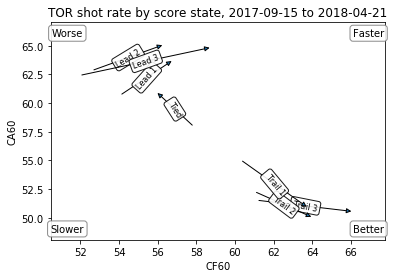

In [35]:
team_score_shot_rate.team_score_shot_rate_scatter("TOR", 2017)

In [36]:
pbp.columns

Index(['Actor', 'ActorRole', 'Event', 'FocusTeam', 'Game', 'Home', 'Index',
       'MinSec', 'Note', 'OppScore', 'OppStrength', 'Period', 'Recipient',
       'RecipientRole', 'Road', 'Team', 'TeamScore', 'TeamStrength', 'Time',
       'X', 'Y'],
      dtype='object')

In [37]:
team = teams.get_team_toi(2017, "TOR")
team


,FocusTeam,Game,Home,Opp1,Opp2,Opp3,Opp4,Opp5,Opp6,OppG,...,Team1,Team2,Team3,Team4,Team5,Team6,TeamG,TeamScore,TeamStrength,Time
0,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,1
1,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,2
2,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,3
3,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,4
4,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,5
5,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,6
6,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,7
7,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,8
8,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,9
9,10,20001,52,8476460,8473618,8471218.0,8470834.0,8470828.0,NaN,8473461.0,...,8479458,8473463,8466139.0,8475172.0,8474581.0,NaN,8475883.0,NaN,5,10


In [38]:
team.columns

Index(['FocusTeam', 'Game', 'Home', 'Opp1', 'Opp2', 'Opp3', 'Opp4', 'Opp5',
       'Opp6', 'OppG', 'OppScore', 'OppStrength', 'Road', 'Team1', 'Team2',
       'Team3', 'Team4', 'Team5', 'Team6', 'TeamG', 'TeamScore',
       'TeamStrength', 'Time'],
      dtype='object')